In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-20062018/IBM_2006-01-01_to_2018-01-01.csv


In [3]:
df = pd.read_csv("../input/ibm-20062018/IBM_2006-01-01_to_2018-01-01.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


This is clearly a time series prediction problem, thus we use LSTM. 
<br> Inputs to LSTM at any state is current input, previous hidden state and previous memory state.
<br> Outputs of LSTM are current hidden state and current memory state

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
import datetime
df['year'] = pd.DatetimeIndex(df['Date']).year
df.head()

,Date,Open,High,Low,Close,Volume,Name,year
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM,2006
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM,2006
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM,2006
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM,2006
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM,2006


In [128]:
# get the training set from 2006 to 2016 data and columns open and high
train_df = df[df['year']<2017]
train_set = train_df[['High']].values

# get the test set from 2017 onwards and columns open and high
test_df = df[df['year']>2016]
test_set = test_df[['High']].values

In [7]:
train_df

,Date,Open,High,Low,Close,Volume,Name,year
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM,2006
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM,2006
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM,2006
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM,2006
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM,2006
...,...,...,...,...,...,...,...,...
2764,2016-12-23,167.00,167.49,166.45,166.71,1701228,IBM,2016
2765,2016-12-27,166.98,167.98,166.85,167.14,1397455,IBM,2016
2766,2016-12-28,167.29,167.74,166.00,166.19,1757500,IBM,2016
2767,2016-12-29,166.02,166.99,166.00,166.60,1663542,IBM,2016


In [9]:
train_set

array([[ 82.55],
       [ 82.5 ],
       [ 82.9 ],
       ...,
       [167.74],
       [166.99],
       [166.7 ]])

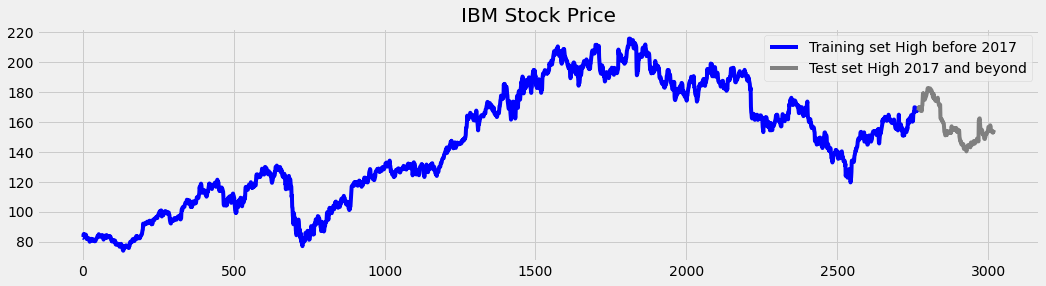

In [10]:
# Plotting the train and test High values
train_df['High'].plot(figsize=(16,4), color = 'blue', legend=True)
test_df['High'].plot(figsize=(16,4), color = 'gray', legend=True)

plt.legend(['Training set High before 2017', 'Test set High 2017 and beyond'])
plt.title('IBM Stock Price')
plt.show()

In [129]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)
train_set_scaled

array([[0.06065089],
       [0.06029868],
       [0.06311637],
       ...,
       [0.66074951],
       [0.65546633],
       [0.6534235 ]])

In [12]:
train_set_scaled.shape

(2769, 1)

In [130]:
# binning the training data into bins of size 60 timesteps
X_train = []
y_train = []

for i in range(60,2769):
    X_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])
    
X_train = np.array(X_train)   # shape: (2709,60)
y_train = np.array(y_train)   # every element from 60 to 2769 -- shape: 2709

In [14]:
X_train

array([[0.06065089, 0.06029868, 0.06311637, ..., 0.0656523 , 0.06656805,
        0.06769513],
       [0.06029868, 0.06311637, 0.0781206 , ..., 0.06656805, 0.06769513,
        0.06875176],
       [0.06311637, 0.0781206 , 0.07262609, ..., 0.06769513, 0.06875176,
        0.06804734],
       ...,
       [0.594745  , 0.59587208, 0.59094111, ..., 0.66420118, 0.65898845,
        0.66244012],
       [0.59587208, 0.59094111, 0.58812342, ..., 0.65898845, 0.66244012,
        0.66074951],
       [0.59094111, 0.58812342, 0.59002536, ..., 0.66244012, 0.66074951,
        0.65546633]])

In [15]:
y_train

array([0.06875176, 0.06804734, 0.06797689, ..., 0.66074951, 0.65546633,
       0.6534235 ])

In [131]:
# Reshaping training set for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.06065089],
        [0.06029868],
        [0.06311637],
        ...,
        [0.0656523 ],
        [0.06656805],
        [0.06769513]],

       [[0.06029868],
        [0.06311637],
        [0.0781206 ],
        ...,
        [0.06656805],
        [0.06769513],
        [0.06875176]],

       [[0.06311637],
        [0.0781206 ],
        [0.07262609],
        ...,
        [0.06769513],
        [0.06875176],
        [0.06804734]],

       ...,

       [[0.594745  ],
        [0.59587208],
        [0.59094111],
        ...,
        [0.66420118],
        [0.65898845],
        [0.66244012]],

       [[0.59587208],
        [0.59094111],
        [0.58812342],
        ...,
        [0.65898845],
        [0.66244012],
        [0.66074951]],

       [[0.59094111],
        [0.58812342],
        [0.59002536],
        ...,
        [0.66244012],
        [0.66074951],
        [0.65546633]]])

In [17]:
X_train.shape[1]

60

## LSTM architecture

In [19]:
# Model
# -----------------------------------------------------------------------------------------------------#
# model structure would be Sequential (RNN) and then we add LSTM layers in it
model = Sequential()

# 1st LSTM layer
# X_train.shape[1] = 60 -- input shape should be 60,1
model.add(LSTM( units=50, return_sequences=True, input_shape=(X_train.shape[1], 1) ))
# Dropout layer -- randomly sets inputs to 0 to prevent overfitting
model.add(Dropout(0.2))

# 2nd LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# 3rd LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Output Dense layer - normal deeply connected layer with default linear activation function
model.add(Dense(units=1))
# -----------------------------------------------------------------------------------------------------#


# Compiling the RNN model
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting to training set
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 12s 80ms/step - loss: 0.0641
Epoch 2/50
85/85 [==============================] - 7s 82ms/step - loss: 0.0169
Epoch 3/50
85/85 [==============================] - 7s 79ms/step - loss: 0.0119
Epoch 4/50
85/85 [==============================] - 7s 80ms/step - loss: 0.0098
Epoch 5/50
85/85 [==============================] - 7s 80ms/step - loss: 0.0081
Epoch 6/50
85/85 [==============================] - 7s 80ms/step - loss: 0.0072
Epoch 7/50
85/85 [==============================] - 7s 82ms/step - loss: 0.0073
Epoch 8/50
85/85 [==============================] - 7s 79ms/step - loss: 0.0062
Epoch 9/50
85/85 [==============================] - 7s 80ms/step - loss: 0.0065
Epoch 10/50
85/85 [==============================] - 7s 80ms/step - loss: 0.0061
Epoch 11/50
85/85 [==============================] - 7s 83ms/step - loss: 0.0058
Epoch 12/50
85/85 [==============================] - 7s 82ms/step - loss: 0.0058
Epoch 13/50
85/85 [=================

In [116]:
test_set.shape

(251, 1)

In [118]:
# Preparing X_test and predicting the prices
test_set_scaled = sc.transform(test_set)
test_set_scaled.shape
X_test = []
for i in range(60,251):
    X_test.append(test_set_scaled[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

predicted_stock_price = model.predict(X_test)

In [119]:
predicted_stock_price.shape

(191, 60, 1)

In [120]:
y_pred = []
for i in range(0,191):
    y_pred.append(predicted_stock_price[i,0])
    
for i in range(0,60):
    y_pred.append(predicted_stock_price[190,i])
    
y_pred = np.array(y_pred)
y_pred = sc.inverse_transform(y_pred)

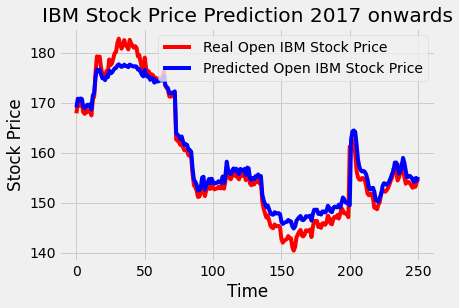

In [122]:
plot_predictions(test_set, y_pred)

In [127]:
# Evaluating the model
import math

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse
    

print("The root mean squared error is: ", return_rmse(test_set, y_pred))
print("the R-square of the mode is: ", r2_score(test_set, y_pred))

The root mean squared error is:  2.233914841230035
the R-square of the mode is:  0.966257590629757


*Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately.

## Model had good performance!
<br>
<br>

## GRU architecture

<br>GRUs have a reset gate and an update gate:
1. Reset gate combines the new input to previous memory, and determines how much of the previous state to keep.
2. Update gate is the combination of forget gate and input gate of LSTM
3. They do not have the output gate.

<br> Hence they are much less complex than LSTM and could be trained faster and generalized on smaller amount of data. However for large data, complex LSTMs might perform better.

In [135]:
#X_train
print(X_train.shape)

(2709, 60, 1)


In [133]:
y_train

array([0.06875176, 0.06804734, 0.06797689, ..., 0.66074951, 0.65546633,
       0.6534235 ])

In [174]:
# GRU model
#----------------------------------------------------------------------------------------------------#

# RNN sequential structure
model_gru = Sequential()

# 1st GRU layer
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model_gru.add(Dropout(0.2))

# 2nd GRU layer
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model_gru.add(Dropout(0.2))

# 3rd GRU layer
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model_gru.add(Dropout(0.2))

# 4th GRU layer
model_gru.add(GRU(units=50, activation='tanh'))
model_gru.add(Dropout(0.2))

# Output Dense layer
model_gru.add(Dense(units=1))

#----------------------------------------------------------------------------------------------------#



# Compiling the GRU model
model_gru.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

model_gru.fit(X_train, y_train, epochs=50, batch_size=150)

Epoch 1/50
19/19 [==============================] - 11s 227ms/step - loss: 0.1756
Epoch 2/50
19/19 [==============================] - 5s 238ms/step - loss: 0.0443
Epoch 3/50
19/19 [==============================] - 5s 247ms/step - loss: 0.0121
Epoch 4/50
19/19 [==============================] - 4s 234ms/step - loss: 0.0049
Epoch 5/50
19/19 [==============================] - 5s 241ms/step - loss: 0.0042
Epoch 6/50
19/19 [==============================] - 5s 237ms/step - loss: 0.0036
Epoch 7/50
19/19 [==============================] - 5s 238ms/step - loss: 0.0039
Epoch 8/50
19/19 [==============================] - 5s 239ms/step - loss: 0.0037
Epoch 9/50
19/19 [==============================] - 5s 240ms/step - loss: 0.0035
Epoch 10/50
19/19 [==============================] - 5s 249ms/step - loss: 0.0035
Epoch 11/50
19/19 [==============================] - 5s 238ms/step - loss: 0.0033
Epoch 12/50
19/19 [==============================] - 4s 235ms/step - loss: 0.0031
Epoch 13/50
19/19 [=====

In [179]:
# Preparing X_test and predicting the prices
test_set_scaled = sc.transform(test_set)
test_set_scaled.shape
X_test = []
for i in range(60,251):
    X_test.append(test_set_scaled[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

predicted_stock_price = model_gru.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [177]:
test_set_reshaped = test_set[60:]
test_set_reshaped.shape

(191, 1)

In [181]:
predicted_stock_price.shape

(191, 1)

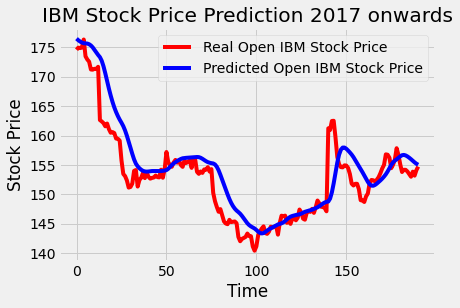

In [182]:
plot_predictions(test_set_reshaped, predicted_stock_price)

In [185]:
print("The root mean squared error of GRU model is: ", return_rmse(test_set_reshaped, predicted_stock_price))
print("the R-square of the GRU model is: ", r2_score(test_set_reshaped, predicted_stock_price))

The root mean squared error of GRU model is:  3.6757943466436314
the R-square of the GRU model is:  0.7625644383565842


### GRU performs much better that LSTM in this case